In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
plt.style.use('seaborn-poster')

In [3]:
date = '103120'
learned = np.load('learned-' + date + '.npz')
dat = loadmat('/tigress/architv/ORGANIZED_CODE_FOR_UPLOAD/tapi_dose.mat')

In [4]:
tapi_concentrations = np.array([0,0,0,0, 5,5,5,5,5, 10,10,10,10,10, 20,20,20,20,20])
cs = np.unique(tapi_concentrations)

In [5]:
def lognormalPDF_np(x, mu, sigma):
    x[x == 0] = 1e-100
    numerator = np.square(np.log(x) - mu)
    denominator = 2*np.square(sigma)
    exponent = np.exp(-np.divide(numerator,denominator))
    multiplier = 1./(np.sqrt(2*np.pi) * np.multiply(x, sigma))
    pdf = np.multiply(multiplier, exponent)
    pdf[np.isnan(pdf)] = 0.
    return pdf

In [6]:
def return_intensity_plots(well, nt = 1000, cells_to_plot = [1,95,97], tlim = [100,200]):
    b = learned['b'][0,well]
    mu = learned['mu'][0,well]
    a = learned['a'][0,well]
    ajj = learned['ajj'][0,well]
    bjj = learned['bjj'][0,well]
    bm = 0
    t_exp = dat['well'][0][well]['t']
    traces = dat['well'][0][well]['PeakTimes']
    events = []
    for j in range(len(traces[0])):
        events.append(np.reshape(traces[0][j],-1).astype(np.float64))
    y_flat = np.hstack(events)
    x = dat['well'][0][well]['x']
    y = dat['well'][0][well]['y']
    coords = np.vstack((x[0],y[0])).T
    peaks = events
    which_cell = np.zeros(len(y_flat))
    i0 = 0
    for i in range(len(peaks)):
        i1 = i0 + len(peaks[i])
        which_cell[i0:i1] = i
        i0 = i1

    y_sorted = np.sort(y_flat)
    cells_sorted = which_cell[np.argsort(y_flat)].astype(np.int)
    d = squareform(pdist(coords))

    tmax = np.max(y_sorted) + 10
    t = np.linspace(0,tmax,nt)
    
    N = x.shape[1]
    ci = np.zeros((N,nt))
    
    cmu = np.zeros((N,nt))
    cajj = np.zeros((N,nt))
    cab = np.zeros((N,nt))
    for j in range(N):
        ci0 = mu * np.ones((1,nt))
        cmu[j] = ci0
        for i in range(len(y_sorted)):
            dt = np.multiply(t - y_sorted[i], t > y_sorted[i])
            if cells_sorted[i] == j:
                cii = ajj * a * lognormalPDF_np(dt, bm, bjj*b)
                cajj[j] += np.reshape(np.multiply(cii, t > y_sorted[i]), -1)
            else:
                cii = a * lognormalPDF_np(dt, bm, b) * (d[j,cells_sorted[i]] < 60.)
                cab[j] += np.reshape(np.multiply(cii, t > y_sorted[i]), -1)
            cii = np.multiply(cii, t > y_sorted[i])
            ci0 += cii
        ci[j] = ci0
    return ci, cmu, cajj, cab
#     fig, ax = plt.subplots(len(cells_to_plot),1,sharex = True)
#     ix = 0
#     for i in cells_to_plot:
#         for j in range(len(peaks[i])):
#             ax[ix].plot(np.array([peaks[i][j],peaks[i][j]]), [np.min(ci[i]),np.max(ci[i])], 'k--')
#             pass
#         #ax[i].scatter(peaks[i], 0.5*np.ones(npeaks), c = 'k', s = 5e4, marker = '|')
#         ax[ix].plot(t, ci[i], color = 'k', linewidth = 1.)
#         ax[ix].plot(t, mu * np.ones(len(ci[i])), linewidth = 1., c = 'r')
#         ax[ix].set_ylabel('$\lambda_{' + str(i+1) + '}$')
#         ix += 1
#     ax[len(cells_to_plot)-1].set_xlabel('t')
#     plt.show()
    
#     fig, ax = plt.subplots(len(cells_to_plot),1,sharex = True)
#     ix = 0

#     for i in cells_to_plot:
#         for j in range(len(peaks[i])):
#             ax[ix].plot(np.array([peaks[i][j],peaks[i][j]]), [0,np.max(ci[i])], 'k--', linewidth = 0.5)
#             pass
#         #ax[i].scatter(peaks[i], 0.5*np.ones(npeaks), c = 'k', s = 5e4, marker = '|')
#         ax[ix].stackplot(t, cmu[i], cajj[i], cab[i], labels = ['Autonomous', 'Self-Excitation', 'Spatial-Excitation'])
#         ax[ix].set_ylabel('$\lambda_{' + str(i+1) + '}$')
#         ax[ix].set_xlim(tlim)
#         ix += 1
#     ax[len(cells_to_plot)-1].set_xlabel('t')
#     ax[0].legend(loc = 'lower left')
#     plt.show()
    
#     plt.scatter(x[0], y[0], c = np.mean(cab, axis = 1), cmap = 'Blues', edgecolor = 'b')
#     plt.colorbar()
#     plt.show()

In [7]:
ci, cmu, cajj, cab = return_intensity_plots(4)

In [8]:
well = 4
b = learned['b'][0,well]
mu = learned['mu'][0,well]
a = learned['a'][0,well]
bm = 0
t_exp = dat['well'][0][well]['t']
traces = dat['well'][0][well]['PeakTimes']
events = []
for j in range(len(traces[0])):
    events.append(np.reshape(traces[0][j],-1).astype(np.float64))
y_flat = np.hstack(events)
x = dat['well'][0][well]['x']
y = dat['well'][0][well]['y']
coords = np.vstack((x[0],y[0])).T
peaks = events
which_cell = np.zeros(len(y_flat))
i0 = 0
for i in range(len(peaks)):
    i1 = i0 + len(peaks[i])
    which_cell[i0:i1] = i
    i0 = i1
nt = 1000
y_sorted = np.sort(y_flat)
cells_sorted = which_cell[np.argsort(y_flat)].astype(np.int)
d = squareform(pdist(coords))
tmax = np.max(y_sorted) + 10
t = np.linspace(0,tmax,nt)

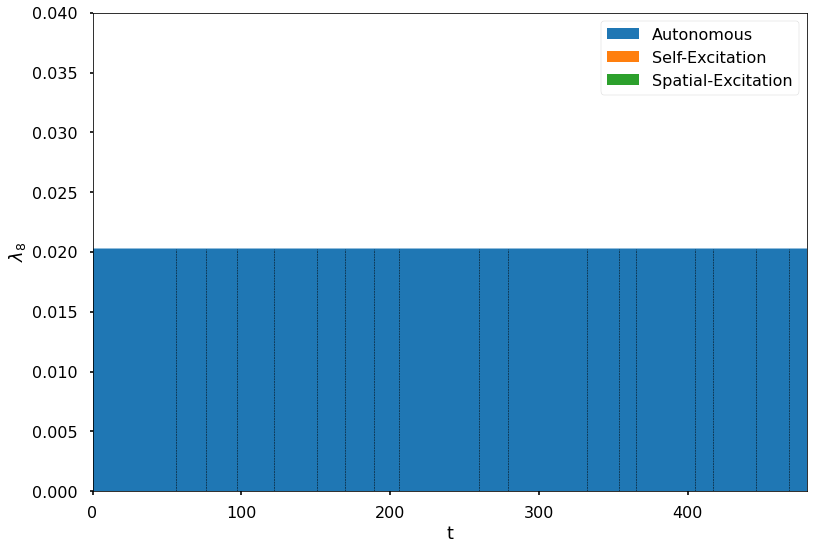

In [9]:
#tlim = [200,250]
tlim = [0, 480]
i = 7
for j in range(len(peaks[i])):
    plt.plot(np.array([peaks[i][j],peaks[i][j]]), [0,np.max(ci[i])], 'k--', linewidth = 0.5)
    pass
#ax[i].scatter(peaks[i], 0.5*np.ones(npeaks), c = 'k', s = 5e4, marker = '|')
plt.stackplot(t, cmu[i], cajj[i], cab[i], labels = ['Autonomous', 'Self-Excitation', 'Spatial-Excitation'])
plt.ylabel('$\lambda_{' + str(i+1) + '}$')
plt.xlim(tlim)
plt.ylim([0,0.04])
plt.xlabel('t')
plt.legend()
plt.show()

In [10]:
# return_intensity_plots(4, tlim = [100, 150], cells_to_plot = [0,7])

In [11]:
def lognormalPDF_single(x, mu, sigma):
    if x == 0: 
        return 0
    numerator = np.square(np.log(x) - mu)
    denominator = 2*np.square(sigma)
    exponent = np.exp(-np.divide(numerator,denominator))
    multiplier = 1./(np.sqrt(2*np.pi) * np.multiply(x, sigma))
    pdf = np.multiply(multiplier, exponent)
    pdf[np.isnan(pdf)] = 0.
    return pdf

In [12]:
def conditional_spatial_plot(well):
    b = learned['b'][0,well]
    mu = learned['mu'][0,well]
    a = learned['a'][0,well]
    ajj = learned['ajj'][0,well]
    bjj = learned['bjj'][0,well]
    bm = 0
    t_exp = dat['well'][0][well]['t']
    traces = dat['well'][0][well]['PeakTimes']
    events = []
    for j in range(len(traces[0])):
        events.append(np.reshape(traces[0][j],-1).astype(np.float64))
    y_flat = np.hstack(events)
    x = dat['well'][0][well]['x']
    y = dat['well'][0][well]['y']
    coords = np.vstack((x[0],y[0])).T
    peaks = events
    which_cell = np.zeros(len(y_flat))
    i0 = 0
    for i in range(len(peaks)):
        i1 = i0 + len(peaks[i])
        which_cell[i0:i1] = i
        i0 = i1

    y_sorted = np.sort(y_flat)
    cells_sorted = which_cell[np.argsort(y_flat)].astype(np.int)
    d = squareform(pdist(coords))

    tmax = np.max(y_sorted) + 10
    #t = np.linspace(0,tmax,nt)
    
    N = x.shape[1]
    peak_likelihood = np.zeros((4,len(y_sorted))) # row 0 - mu, row 1 - spatial, row 2 - self, row 3 - total
    for j in range(1,len(y_sorted)):
        peak_likelihood[0,j] = mu
        for i in range(len(y_sorted[:j-1])):
            dt = y_sorted[j] - y_sorted[i]
            if cells_sorted[i] == j:
                peak_likelihood[2,j] += ajj * a * lognormalPDF_single(dt, bm, bjj*b)
            else:
                peak_likelihood[1,j] += a * lognormalPDF_single(dt, bm, b) * (d[cells_sorted[j],cells_sorted[i]] < 60.)
        peak_likelihood[3,j] += peak_likelihood[0,j] + peak_likelihood[1,j] + peak_likelihood[2,j]
    percent_self = np.divide(peak_likelihood[2],peak_likelihood[3])
    percent_spatial = np.divide(peak_likelihood[1], peak_likelihood[3])
    
    spatial_pct = np.zeros(N)
    self_pct = np.zeros(N)
    npeaks = np.zeros(N)
    for j in range(N):
        spatial_pct[j] = np.mean(percent_spatial[cells_sorted == j])
        self_pct[j] = np.mean(percent_self[cells_sorted == j])
        npeaks[j] = np.sum(cells_sorted == j)
    #return spatial_pct, self_pct, npeaks, x, y

#     fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21,10), sharey = True)
   
#     pos0 = ax[0].scatter(x[0], y[0], 
#                          c = 100 * spatial_pct, cmap = 'Blues', edgecolor = 'b', vmin = 0, vmax = 4)
#     ax[0].set_xlim([0, 700])
#     ax[0].set_ylim([0, 700])
#     ax[0].set_title('Mean Spatial Contribution')
#     fig.colorbar(pos0, ax = ax[0], orientation = 'horizontal')
    
#     pos1 = ax[1].scatter(x[0], y[0], c = 100 * self_pct, cmap = 'Blues', edgecolor = 'b', vmin = 0, vmax = 2.5)
#     ax[1].set_xlim([0, 700])
#     ax[1].set_ylim([0, 700])
#     ax[1].set_title('Mean Self-Exciting Contribution')
#     fig.colorbar(pos1, ax = ax[1], orientation = 'horizontal')
    
#     pos2 = ax[2].scatter(x[0], y[0], c = npeaks, cmap = 'Blues', edgecolor = 'b', vmin = 0, vmax = 25)
#     ax[2].set_xlim([0, 700])
#     ax[2].set_ylim([0, 700])
#     ax[2].set_title('No. of Peaks')
#     fig.colorbar(pos2, ax = ax[2], orientation = 'horizontal')
#     #plt.colorbar()
#     plt.show()
    return np.nanmean(spatial_pct), np.nanmean(self_pct), spatial_pct, self_pct

In [13]:
len(tapi_concentrations)

19

In [14]:
# fig, ax = plt.subplots(nrows = 19, ncols = 3, figsize = (20,120), sharey = True, sharex = True)
# for i in range(1,20):
#     print(i)
#     spatial_pct, self_pct, npeaks, x, y = conditional_spatial_plot(i)
#     pos0 = ax[i-1,0].scatter(x[0], y[0], c = 100 * spatial_pct, cmap = 'Blues', edgecolor = 'b',
#                         vmin = 0, vmax = 4)
#     ax[i-1,0].set_xlim([0, 700])
#     ax[i-1,0].set_ylim([0, 700])

#     ax[i-1,0].set_ylabel('Well ' + str(i) + ', ' + str(tapi_concentrations[i-1]) + ' $\mu$M')
    
    
#     pos1 = ax[i-1,1].scatter(x[0], y[0], c = 100 * self_pct, cmap = 'Blues', edgecolor = 'b',
#                         vmin = 0, vmax = 2)
#     ax[i-1,1].set_xlim([0, 700])
#     ax[i-1,1].set_ylim([0, 700])
    
    
    
#     pos2 = ax[i-1,2].scatter(x[0], y[0], c = npeaks, cmap = 'Blues', edgecolor = 'b',
#                         vmin = 0, vmax = 25)
#     ax[i-1,2].set_xlim([0, 700])
#     ax[i-1,2].set_ylim([0, 700])
    
#     if i == 1:
#         ax[i-1,0].set_title('Mean Spatial Contribution')
#         ax[i-1,1].set_title('Mean Self-Exciting Contribution')
#         ax[i-1,2].set_title('No. of Peaks')
        
#     if i == 19:
#         fig.colorbar(pos0, ax = ax[18,0], orientation = 'horizontal')
#         fig.colorbar(pos1, ax = ax[18,1], orientation = 'horizontal')
#         fig.colorbar(pos2, ax = ax[18,2], orientation = 'horizontal')
#     #plt.colorbar()
# plt.savefig('spatial-ratio.pdf')

In [15]:
spatial_pct = np.zeros(20)
self_pct = np.zeros(20)
for i in range(1,20):
    print(str(i) + ' : ' + str(tapi_concentrations[i-1]))
    spatial_pct[i], self_pct[i], c, d = conditional_spatial_plot(i)

1 : 0


<ipython-input-12-d53aa37409c7>:43: RuntimeWarning: invalid value encountered in true_divide
  percent_self = np.divide(peak_likelihood[2],peak_likelihood[3])
<ipython-input-12-d53aa37409c7>:44: RuntimeWarning: invalid value encountered in true_divide
  percent_spatial = np.divide(peak_likelihood[1], peak_likelihood[3])
/usr/licensed/anaconda3/2020.7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/licensed/anaconda3/2020.7/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2 : 0
3 : 0
4 : 0
5 : 5
6 : 5
7 : 5
8 : 5
9 : 5
10 : 10
11 : 10
12 : 10
13 : 10
14 : 10
15 : 20
16 : 20
17 : 20
18 : 20
19 : 20


In [16]:
np.argsort(spatial_pct)

array([ 0,  9, 15, 11, 12, 17, 18,  5,  8, 10, 16,  2,  7,  1, 13, 19, 14,
        6,  3,  4])

In [17]:
def return_stats(mu):

    ixs = [0,4,9,14,19]
    control = mu[0:4]
    
    means = np.zeros(4)
    SEs = np.zeros(4)
    ps = np.zeros(4)
    Ts = np.zeros(4)
    
    
    for i in range(len(cs)):
        low = ixs[i]
        high = ixs[i+1]
        #print(cs[i])
        sample = mu[low:high]
        means[i] = np.mean(sample)
        SEs[i] = stats.sem(sample)
        if i > 0:
            Ts[i], ps[i] = stats.ttest_ind(control, sample, equal_var = False)
            #print(stats.ttest_ind(control, sample, equal_var = False))
    return means, SEs, ps, Ts

In [18]:
means, SEs, ps, Ts = return_stats(spatial_pct[1:])

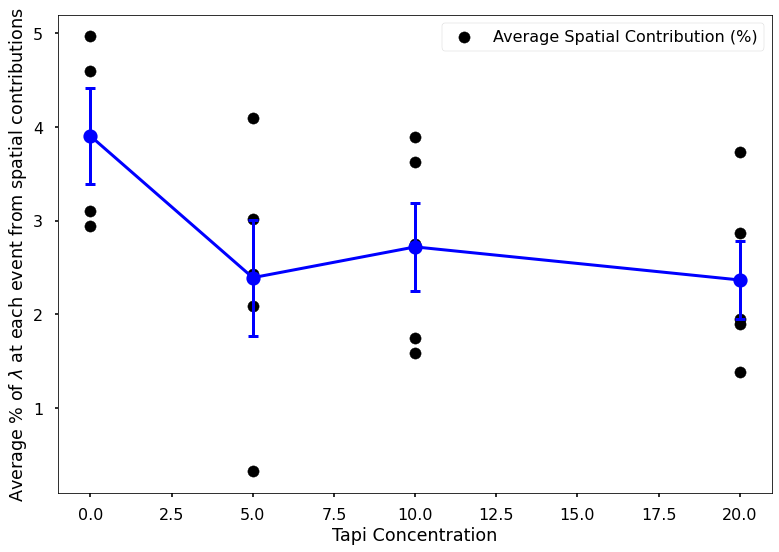

In [19]:
plt.scatter(tapi_concentrations, 100 * spatial_pct[1:], label = 'Average Spatial Contribution (%)', c = 'k')
plt.errorbar([0,5,10,20], 100 * means, yerr = 100 * SEs, fmt = 'bo-', 
                 capsize= 5, elinewidth=3, markeredgewidth = 3, linewidth = 3)
#plt.scatter(tapi_concentrations, self_pct[1:], label = 'Average Spatial Contribution (%)')
plt.legend()
plt.xlabel('Tapi Concentration')
plt.ylabel('Average % of $\lambda$ at each event from spatial contributions')
plt.savefig('tapi-spatial-pct-' + date + '.pdf')


In [20]:
# np.argmax(spatial_pct)

In [21]:
# a,b,c,d = conditional_spatial_plot(4)

In [22]:
# well = 4
# traces = dat['well'][0][well]['PeakTimes']
# events = []
# for j in range(len(traces[0])):
#     events.append(np.reshape(traces[0][j],-1).astype(np.float64))
# y_flat = np.hstack(events)
# x = dat['well'][0][well]['x']
# y = dat['well'][0][well]['y']
# coords = np.vstack((x[0],y[0])).T

In [23]:
# d = squareform(pdist(coords))